In [85]:
# ======================================================
#  Imports
# ======================================================
import pandas as pd
import random
import time
import os
import itertools
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# ======================================================
#  Step 1.  Load Original Dataset
# ======================================================
df = pd.read_csv("Market_Basket_Optimisation.csv", header=None)
transactions = []
for i in range(df.shape[0]):
    items = [str(df.values[i, j]) for j in range(df.shape[1]) if str(df.values[i, j]) != 'nan']
    if items:
        transactions.append(items)

unique_items = sorted(set([i for t in transactions for i in t]))
print(f"Loaded dataset with {len(transactions)} transactions and {len(unique_items)} unique items.\n")

random.seed(42)
os.makedirs("new_generated_datasets", exist_ok=True)

In [ ]:
# ======================================================
#  Step 2.  Generate Group A — vary #items, same #transactions
# ======================================================
target_trans = 4000
item_counts = [45, 60, 110]
A_paths = []

for count in item_counts:
    selected_items = random.sample(unique_items, count)
    filtered = [[i for i in t if i in selected_items] for t in transactions]
    filtered = [t for t in filtered if t]
    if len(filtered) > target_trans:
        filtered = random.sample(filtered, target_trans)
    max_len = max(len(t) for t in filtered)
    df_out = pd.DataFrame([t + [None]*(max_len - len(t)) for t in filtered])
    path = f"new_generated_datasets/A_items_{count}_transactions_{len(filtered)}.csv"
    df_out.to_csv(path, index=False, header=False)
    A_paths.append(path)
    print(f"✅ Saved {path}")

In [ ]:
# ======================================================
#  Step 3.  Generate Group B — vary #transactions, same #items
# ======================================================
trans_counts = [1000, 3000, 7000]
B_paths = []

# 1️⃣ Pick 110 items from the full item universe
all_unique_items = sorted(set([item for sublist in transactions for item in sublist]))
selected_items = random.sample(all_unique_items, 110)

for count in trans_counts:
    # 2️⃣ Sample transactions that contain only the selected 110 items
    selected_trans = random.sample(transactions, min(count, len(transactions)))
    selected_trans = [
        [item for item in t if item in selected_items]
        for t in selected_trans
        if any(item in selected_items for item in t)
    ]

    # 3️⃣ Ensure every selected item appears at least once
    current_items = set([item for t in selected_trans for item in t])
    missing_items = set(selected_items) - current_items

    if missing_items:
        print(f"⚠️ {len(missing_items)} items missing in initial sample of {count} transactions. Adding them manually.")
        for item in missing_items:
            for t in transactions:
                if item in t:
                    selected_trans.append([i for i in t if i in selected_items])
                    break

    # 4️⃣ Trim to desired transaction count
    if len(selected_trans) > count:
        selected_trans = random.sample(selected_trans, count)

    # 5️⃣ Save to CSV
    max_len = max(len(t) for t in selected_trans)
    df_out = pd.DataFrame([t + [None]*(max_len - len(t)) for t in selected_trans])
    filename = f"new_generated_datasets/B_items_110_transactions_{count}.csv"
    df_out.to_csv(filename, index=False, header=False)
    B_paths.append(filename)
    print(f"✅ Saved {filename}")

In [86]:
# ======================================================
# Define a helper function to check transactions & items
# ======================================================
def verify_datasets(paths, group_name):
    print(f"\n🔍 Verifying {group_name} datasets:")
    print(f"{'Dataset':45} | {'Transactions':>12} | {'Unique Items':>13}")
    print("-" * 75)

    for path in paths:
        if not os.path.exists(path):
            print(f"{os.path.basename(path):45} | {'File not found':>25}")
            continue

        df = pd.read_csv(path, header=None)
        n_transactions = df.shape[0]

        unique_items = set()
        for _, row in df.iterrows():
            items = [str(x) for x in row if str(x) != 'nan']
            unique_items.update(items)

        n_unique = len(unique_items)

        print(f"{os.path.basename(path):45} | {n_transactions:12} | {n_unique:13}")

# ======================================================
# Run checks for both groups
# ======================================================
verify_datasets(A_paths, "Group A")
verify_datasets(B_paths, "Group B")



🔍 Verifying Group A datasets:
Dataset                                       | Transactions |  Unique Items
---------------------------------------------------------------------------
A_items_45_transactions_4000.csv              |         4000 |            45
A_items_60_transactions_4000.csv              |         4000 |            60
A_items_110_transactions_4000.csv             |         4000 |           110

🔍 Verifying Group B datasets:
Dataset                                       | Transactions |  Unique Items
---------------------------------------------------------------------------
B_items_110_transactions_1000.csv             |          973 |           110
B_items_110_transactions_3000.csv             |         2908 |           110
B_items_110_transactions_7000.csv             |         6759 |           110


In [87]:
# ======================================================
#  Step 4.  Helper — one-hot encoding
# ======================================================
def load_onehot(csv_path):
    df = pd.read_csv(csv_path, header=None)
    basket = [[str(df.values[i, j]) for j in range(df.shape[1]) if str(df.values[i, j]) != 'nan']
              for i in range(df.shape[0])]
    items = sorted(set([i for t in basket for i in t]))
    df_bool = pd.DataFrame([[1 if i in t else 0 for i in items] for t in basket], columns=items)
    return basket, df_bool, items

In [88]:
# ======================================================
#  Step 5.  Apriori algorithm
# ======================================================
def run_apriori(csv_path, min_support=0.02, min_conf=0.2):
    basket, df_bool, items = load_onehot(csv_path)

    start = time.time()
    freq_items = apriori(df_bool, min_support=min_support, max_len=3, use_colnames=True)
    t_itemset = time.time() - start

    start = time.time()
    rules = association_rules(freq_items, metric="confidence", min_threshold=min_conf)
    t_rules = time.time() - start

    total = t_itemset + t_rules
    return len(basket), len(items), total, t_itemset, t_rules, freq_items, rules

C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] A_items_45_transactions_4000.csv – 4000 trans, 45 items
   Frequent Itemset Gen: 0.7827s | Rule Gen: 0.5948s | Total: 1.3775s


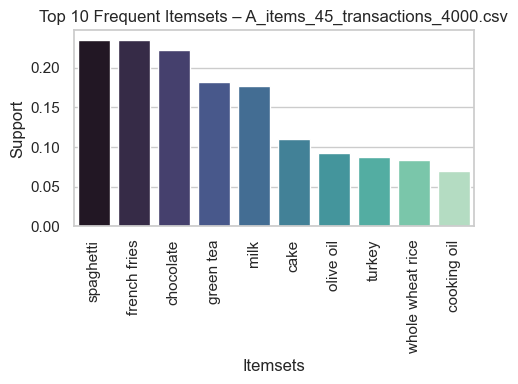


Top 5 Rules by Confidence:
antecedents consequents  support  confidence   lift
  olive oil   spaghetti   0.0320      0.3441 1.4642
cooking oil   spaghetti   0.0228      0.3238 1.3781
       milk   spaghetti   0.0485      0.2752 1.1710
     turkey   spaghetti   0.0230      0.2636 1.1217
  olive oil        milk   0.0235      0.2527 1.4337


C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] A_items_60_transactions_4000.csv – 4000 trans, 60 items
   Frequent Itemset Gen: 0.1541s | Rule Gen: 0.1339s | Total: 0.2880s


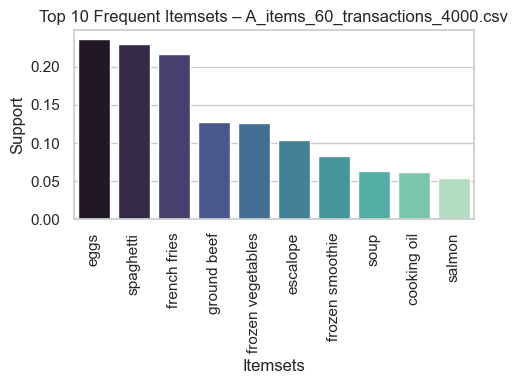


Top 5 Rules by Confidence:
      antecedents consequents  support  confidence   lift
      ground beef   spaghetti   0.0510      0.3977 1.7271
frozen vegetables   spaghetti   0.0362      0.2877 1.2495
frozen vegetables        eggs   0.0298      0.2361 1.0015
        spaghetti ground beef   0.0510      0.2215 1.7271
     french fries        eggs   0.0455      0.2099 0.8904


C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] A_items_110_transactions_4000.csv – 4000 trans, 110 items
   Frequent Itemset Gen: 0.5698s | Rule Gen: 0.5345s | Total: 1.1043s


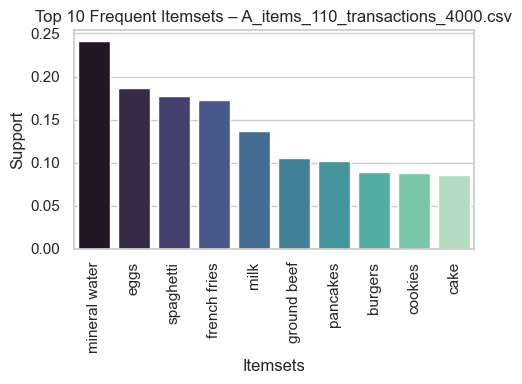


Top 5 Rules by Confidence:
antecedents   consequents  support  confidence   lift
       soup mineral water   0.0240      0.4465 1.8489
  olive oil mineral water   0.0268      0.4213 1.7443
    chicken mineral water   0.0253      0.4040 1.6729
ground beef mineral water   0.0418      0.3967 1.6425
ground beef     spaghetti   0.0402      0.3824 2.1575


C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] B_items_110_transactions_1000.csv – 973 trans, 110 items
   Frequent Itemset Gen: 0.1770s | Rule Gen: 0.1525s | Total: 0.3295s


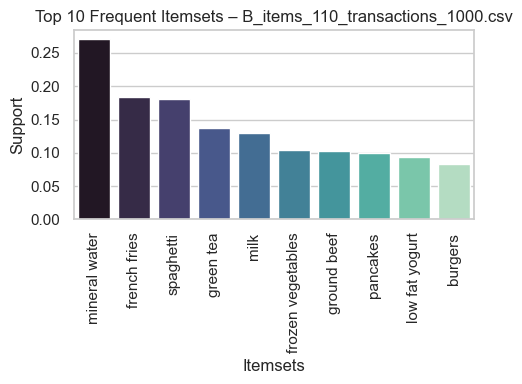


Top 5 Rules by Confidence:
  antecedents   consequents  support  confidence   lift
         soup mineral water   0.0308      0.5263 1.9472
    olive oil mineral water   0.0360      0.4930 1.8238
       salmon mineral water   0.0206      0.4878 1.8047
  ground beef     spaghetti   0.0462      0.4500 2.4878
herb & pepper mineral water   0.0226      0.4490 1.6611


C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] B_items_110_transactions_3000.csv – 2908 trans, 110 items
   Frequent Itemset Gen: 0.4597s | Rule Gen: 0.4197s | Total: 0.8794s


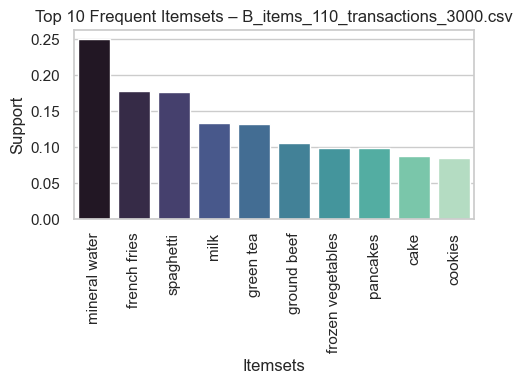


Top 5 Rules by Confidence:
    antecedents   consequents  support  confidence   lift
spaghetti, milk mineral water   0.0206      0.5455 2.1848
           soup mineral water   0.0224      0.4545 1.8207
      olive oil mineral water   0.0334      0.4470 1.7905
       tomatoes mineral water   0.0279      0.4332 1.7350
    ground beef mineral water   0.0457      0.4318 1.7297


C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



⏱ [Apriori] B_items_110_transactions_7000.csv – 6759 trans, 110 items
   Frequent Itemset Gen: 0.9327s | Rule Gen: 0.8874s | Total: 1.8201s


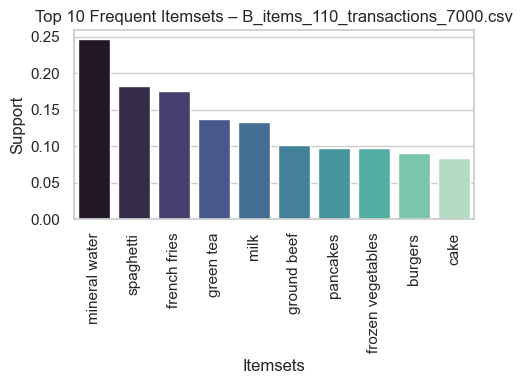


Top 5 Rules by Confidence:
antecedents   consequents  support  confidence   lift
       soup mineral water   0.0237      0.4533 1.8378
ground beef mineral water   0.0428      0.4176 1.6933
  olive oil mineral water   0.0289      0.4167 1.6894
ground beef     spaghetti   0.0413      0.4032 2.2101
cooking oil mineral water   0.0203      0.3914 1.5871


In [89]:
# ======================================================
# Step 6. Run Apriori – Collect and Visualise Results
# ======================================================
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1)

records_apriori = []
for path in A_paths + B_paths:
    n_trans, n_items, t_itemset, t_rules, total_time, freq_items, rules = run_apriori(path)
    total_time = t_itemset + t_rules
    group = "A" if "A_" in path else "B"
    dataset_name = os.path.basename(path)
    
    print(f"\n⏱ [Apriori] {dataset_name} – {n_trans} trans, {n_items} items")
    print(f"   Frequent Itemset Gen: {t_itemset:.4f}s | Rule Gen: {t_rules:.4f}s | Total: {total_time:.4f}s")

    records_apriori.append({
        "dataset": dataset_name,
        "group": group,
        "transactions": n_trans,
        "items": n_items,
        "t_itemset": t_itemset,
        "t_rules": t_rules,
        "total_time": total_time
    })

    # -----------------------------
    # Visualise Top 10 Frequent Itemsets
    # -----------------------------
    if not freq_items.empty:
        freq_items["itemsets_str"] = freq_items["itemsets"].apply(lambda x: ", ".join(sorted(x)))
        top10 = freq_items.sort_values(by="support", ascending=False).head(10)
        plt.figure(figsize=(5, 4))
        sns.barplot(
            data=top10,
            x="itemsets_str",
            y="support",
            hue="itemsets_str",
            legend=False,
            palette="mako"
        )
        plt.xticks(rotation=90, ha="center")
        plt.title(f"Top 10 Frequent Itemsets – {dataset_name}")
        plt.ylabel("Support")
        plt.xlabel("Itemsets")
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No frequent itemsets found (check min_support).")

    # -----------------------------
    # Print Top 5 Association Rules
    # -----------------------------
    if rules is not None and not rules.empty:
        # Round numeric columns to 4 decimal places
        rules = rules.round({"support": 4, "confidence": 4, "lift": 4})

        # Convert frozensets to readable strings
        rules["antecedents"] = rules["antecedents"].apply(lambda x: ", ".join(list(x)))
        rules["consequents"] = rules["consequents"].apply(lambda x: ", ".join(list(x)))

        # Sort and display top 5 rules by confidence
        top_rules = rules.sort_values("confidence", ascending=False).head(5)[
            ["antecedents", "consequents", "support", "confidence", "lift"]
        ]

        print("\nTop 5 Rules by Confidence:")
        print(top_rules.to_string(index=False))
    else:
        print("⚠️ No association rules found.")

# Create DataFrame (for plotting, no export)
df_apriori = pd.DataFrame(records_apriori)

In [90]:
df_apriori.head(10)

,dataset,group,transactions,items,t_itemset,t_rules,total_time
0,A_items_45_transactions_4000.csv,A,4000,45,0.782682,0.594816,1.377498
1,A_items_60_transactions_4000.csv,A,4000,60,0.154115,0.133881,0.287996
2,A_items_110_transactions_4000.csv,A,4000,110,0.569831,0.534488,1.104319
3,B_items_110_transactions_1000.csv,B,973,110,0.177020,0.152459,0.329479
4,B_items_110_transactions_3000.csv,B,2908,110,0.459696,0.419689,0.879386
5,B_items_110_transactions_7000.csv,B,6759,110,0.932727,0.887404,1.820131


In [ ]:
# ======================================================
#  Step 7.  Brute-Force algorithm
# ======================================================
def run_bruteforce(csv_path, min_support=0.02, min_conf=0.2, max_len=3):
    basket, df_bool, items = load_onehot(csv_path)
    n_trans = len(basket)

    # --- generate all candidate itemsets ---
    start = time.time()
    freq = []
    for k in range(1, max_len + 1):
        for combo in itertools.combinations(items, k):
            support = sum(all(i in t for i in combo) for t in basket) / n_trans
            if support >= min_support:
                freq.append((set(combo), support))
    t_itemset = time.time() - start

    # --- association rules ---
    start = time.time()
    rules = []
    for itemset, sup in freq:
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for antecedent in itertools.combinations(itemset, i):
                antecedent, consequent = set(antecedent), itemset - set(antecedent)
                supA = sum(all(x in t for x in antecedent) for t in basket) / n_trans
                supC = sum(all(x in t for x in consequent) for t in basket) / n_trans
                conf = sup / supA if supA else 0
                lift = conf / supC if supC else 0
                if conf >= min_conf:
                    rules.append((antecedent, consequent, sup, conf, lift))
    t_rules = time.time() - start

    # Convert to DataFrame before returning
    df_rules = pd.DataFrame(rules, columns=["antecedents", "consequents", "support", "confidence", "lift"])

    total = t_itemset + t_rules
    return len(basket), len(items), total, t_itemset, t_rules, freq, df_rules

In [ ]:
# ======================================================
# Step 8. Run Brute Force – Collect Results
# ======================================================
records_bf = []
for path in A_paths + B_paths:
    # n_trans, n_items, t_itemset, t_rules, freq_items, rules = run_bruteforce(path)
    n_bf, m_bf, total_bf, t_itemset_bf, t_rules_bf, freq_bf, rules_bf = run_bruteforce(path)
    total_time = t_itemset + t_rules
    group = "A" if "A_" in path else "B"
    print(f"⏱ [BruteForce] {os.path.basename(path)} – {n_bf} trans, {m_bf} items, total {total_bf:.4f}s")

    records_bf.append({
        "dataset": os.path.basename(path),
        "group": group,
        "transactions": n_bf,
        "items": m_bf,
        "t_itemset": t_itemset_bf,
        "t_rules": t_rules_bf,
        "total_time": total_bf
    })

    # -----------------------------
    # Print Top 5 Association Rules
    # -----------------------------
    if rules_bf is not None and not rules_bf.empty:
        # Round numeric columns to 4 decimal places
        rules_bf = rules_bf.round({"support": 4, "confidence": 4, "lift": 4})

        # Convert frozensets to readable strings
        rules_bf["antecedents"] = rules_bf["antecedents"].apply(lambda x: ", ".join(list(x)))
        rules_bf["consequents"] = rules_bf["consequents"].apply(lambda x: ", ".join(list(x)))

        # Sort and display top 5 rules by confidence
        top_rules = rules_bf.sort_values("confidence", ascending=False).head(5)[
            ["antecedents", "consequents", "support", "confidence", "lift"]
        ]

        print("\nTop 5 Rules by Confidence:")
        print(top_rules.to_string(index=False))
    else:
        print("⚠️ No association rules found.")

df_bf = pd.DataFrame(records_bf)

⏱ [BruteForce] A_items_45_transactions_4000.csv – 4000 trans, 45 items, total 64.6884s

Top 5 Rules by Confidence:
antecedents consequents  support  confidence   lift
  olive oil   spaghetti   0.0320      0.3441 1.4642
cooking oil   spaghetti   0.0228      0.3238 1.3781
       milk   spaghetti   0.0485      0.2752 1.1710
     turkey   spaghetti   0.0230      0.2636 1.1217
  olive oil        milk   0.0235      0.2527 1.4337
⏱ [BruteForce] A_items_60_transactions_4000.csv – 4000 trans, 60 items, total 146.0248s

Top 5 Rules by Confidence:
      antecedents consequents  support  confidence   lift
      ground beef   spaghetti   0.0510      0.3977 1.7271
frozen vegetables   spaghetti   0.0362      0.2877 1.2495
frozen vegetables        eggs   0.0298      0.2361 1.0015
        spaghetti ground beef   0.0510      0.2215 1.7271
     french fries        eggs   0.0455      0.2099 0.8904
⏱ [BruteForce] A_items_110_transactions_4000.csv – 4000 trans, 110 items, total 886.0802s

Top 5 Rules by Con

In [ ]:
# ======================================================
# Step 9. Run One Small Brute Force Dataset (Baseline)
# ======================================================
# Use a small dataset from Group A as the baseline
baseline_path = A_paths[0]  # use small dataset as baseline
print(f"\n⚙️ Running baseline brute-force on: {os.path.basename(baseline_path)}")
n_b, m_b, total_b, t_itemset_b, t_rules_b, _, _ = run_bruteforce(baseline_path)
C = total_b / (n_b * (m_b ** 3))
print(f"Baseline brute-force runtime: {total_b:.4f}s (n={n_b}, m={m_b})")
print(f"→ Calibration constant C = {C:.8e}\n")

# Estimate for Apriori datasets
df_apriori["bruteforce_est"] = df_apriori.apply(
    lambda r: C * r["transactions"] * (r["items"] ** 3), axis=1
)


⚙️ Running baseline brute-force on: A_items_45_transactions_4000.csv
Baseline brute-force runtime: 62.1389s (n=4000, m=45)
→ Calibration constant C = 1.70477209e-07



In [ ]:
# ======================================================
# Step 10. Estimate Brute Force Itemset + Rule Generation Times Separately
# ======================================================

# Split total brute-force runtime into itemset vs rule components using same scaling logic.
# We assume both scale similarly with n*m^3, but itemset generation dominates ~80–90%.

# Step 1: Get proportions from baseline run
print("\n📊 Baseline component breakdown:")
print(f"Itemset gen time: {t_itemset_b:.4f}s, Rule gen time: {t_rules_b:.4f}s, Total: {total_b:.4f}s")

p_item = t_itemset_b / total_b
p_rule = t_rules_b / total_b
print(f"Itemset portion: {p_item*100:.1f}%, Rule portion: {p_rule*100:.1f}%\n")

# Step 2: Apply same proportions to estimated runtime for each dataset
df_apriori["bruteforce_itemset_est"] = df_apriori.apply(
    lambda r: (C * r["transactions"] * (r["items"] ** 3)) * p_item, axis=1
)
df_apriori["bruteforce_rule_est"] = df_apriori.apply(
    lambda r: (C * r["transactions"] * (r["items"] ** 3)) * p_rule, axis=1
)

# Step 3: Display results neatly
print("🧮 Estimated Brute Force Runtime Breakdown:")
print(df_apriori[[
    "dataset", "transactions", "items",
    "bruteforce_itemset_est", "bruteforce_rule_est", "bruteforce_est"
]].to_string(index=False, float_format="%.4f"))


📊 Baseline component breakdown:
Itemset gen time: 61.8399s, Rule gen time: 0.2990s, Total: 62.1389s
Itemset portion: 99.5%, Rule portion: 0.5%

🧮 Estimated Brute Force Runtime Breakdown:
                          dataset  transactions  items  bruteforce_itemset_est  bruteforce_rule_est  bruteforce_est
 A_items_45_transactions_4000.csv          4000     45                 61.8399               0.2990         62.1389
 A_items_60_transactions_4000.csv          4000     60                146.5835               0.7088        147.2923
A_items_110_transactions_4000.csv          4000    110                903.2527               4.3680        907.6207
B_items_110_transactions_1000.csv           973    110                219.7162               1.0625        220.7787
B_items_110_transactions_3000.csv          2908    110                656.6647               3.1755        659.8402
B_items_110_transactions_7000.csv          6759    110               1526.2713               7.3808       1533.6520


In [ ]:
# ======================================================
# Step 11. Visualise Runtime
# ======================================================
def plot_runtime(df, algorithm_name):
    df_A = df[df["group"] == "A"]
    df_B = df[df["group"] == "B"]

    # ======================================================
    # Group A: Varying #Unique Items
    # ======================================================
    plt.figure(figsize=(6, 4))
    ax = sns.lineplot(data=df_A, x="items", y="t_itemset", marker="o", label="Itemset Generation")
    sns.lineplot(data=df_A, x="items", y="t_rules", marker="s", label="Rule Generation", ax=ax)
    sns.lineplot(data=df_A, x="items", y="total_time", marker="^", label="Total Time", ax=ax)
    plt.title(f"{algorithm_name} Runtime vs. #Unique Items (Group A)")
    plt.xlabel("#Unique Items"); plt.ylabel("Runtime (s)")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # ======================================================
    # Group B: Varying #Transactions
    # ======================================================
    plt.figure(figsize=(6, 4))
    ax = sns.lineplot(data=df_B, x="transactions", y="t_itemset", marker="o", label="Itemset Generation")
    sns.lineplot(data=df_B, x="transactions", y="t_rules", marker="s", label="Rule Generation", ax=ax)
    sns.lineplot(data=df_B, x="transactions", y="total_time", marker="^", label="Total Time", ax=ax)
    plt.title(f"{algorithm_name} Runtime vs. #Transactions (Group B)")
    plt.xlabel("#Transactions"); plt.ylabel("Runtime (s)")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

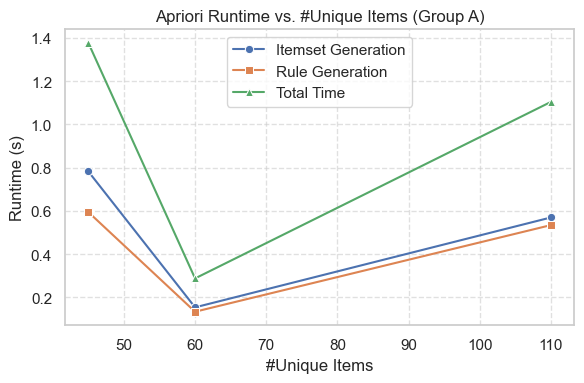

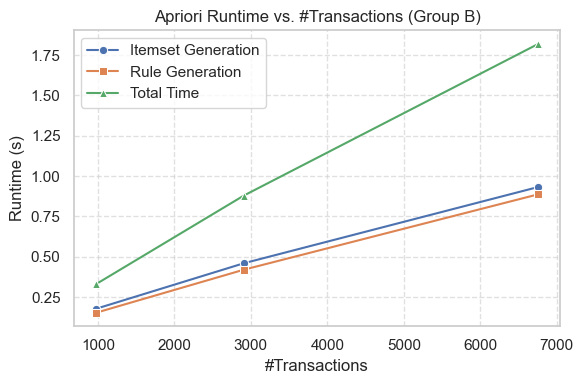

In [110]:
plot_runtime(df_apriori, "Apriori")

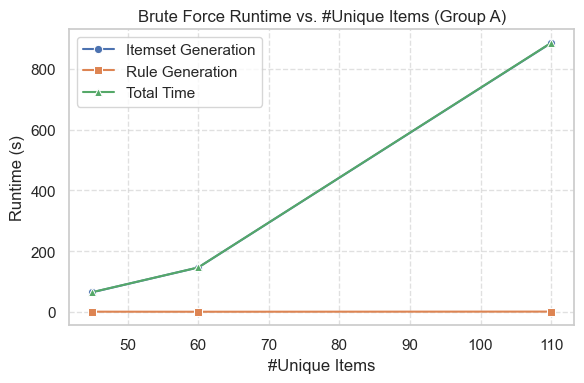

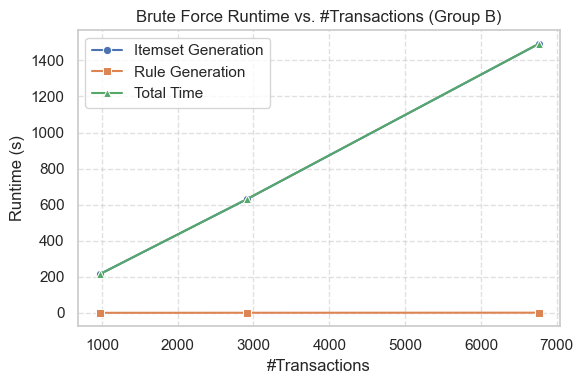

In [ ]:
# =========================
# Plot: Measured Brute-Force (itemset, rules, total)
# =========================

plot_runtime(df_bf, "Brute Force")

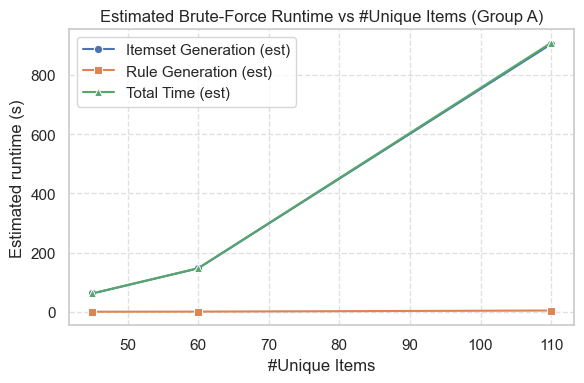

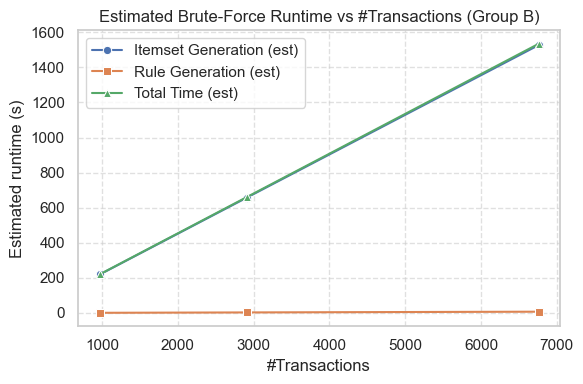

In [ ]:
# =========================
# Plot: Estimated Brute-Force (itemset, rules, total)
# =========================

def plot_estimated_bruteforce(df):
    df_A = df[df["group"] == "A"].sort_values("items")
    df_B = df[df["group"] == "B"].sort_values("transactions")

    # Group A: vs # unique items
    plt.figure(figsize=(6,4))
    ax = sns.lineplot(data=df_A, x="items", y="bruteforce_itemset_est", marker="o", label="Itemset Generation (est)")
    sns.lineplot(data=df_A, x="items", y="bruteforce_rule_est", marker="s", label="Rule Generation (est)", ax=ax)
    sns.lineplot(data=df_A, x="items", y="bruteforce_est", marker="^", label="Total Time (est)", ax=ax)
    ax.set_title("Estimated Brute-Force Runtime vs #Unique Items (Group A)")
    ax.set_xlabel("#Unique Items"); ax.set_ylabel("Estimated runtime (s)")
    ax.grid(True, linestyle="--", alpha=0.6); plt.tight_layout(); plt.show()

    # Group B: vs # transactions
    plt.figure(figsize=(6,4))
    ax = sns.lineplot(data=df_B, x="transactions", y="bruteforce_itemset_est", marker="o", label="Itemset Generation (est)")
    sns.lineplot(data=df_B, x="transactions", y="bruteforce_rule_est", marker="s", label="Rule Generation (est)", ax=ax)
    sns.lineplot(data=df_B, x="transactions", y="bruteforce_est", marker="^", label="Total Time (est)", ax=ax)
    ax.set_title("Estimated Brute-Force Runtime vs #Transactions (Group B)")
    ax.set_xlabel("#Transactions"); ax.set_ylabel("Estimated runtime (s)")
    ax.grid(True, linestyle="--", alpha=0.6); plt.tight_layout(); plt.show()

plot_estimated_bruteforce(df_apriori)

In [120]:
df_apriori.head(10)

,dataset,group,transactions,items,t_itemset,t_rules,total_time,bruteforce_est,bruteforce_itemset_est,bruteforce_rule_est
0,A_items_45_transactions_4000.csv,A,4000,45,0.782682,0.594816,1.377498,62.138943,61.839897,0.299046
1,A_items_60_transactions_4000.csv,A,4000,60,0.154115,0.133881,0.287996,147.292309,146.583459,0.708849
2,A_items_110_transactions_4000.csv,A,4000,110,0.569831,0.534488,1.104319,907.620661,903.252706,4.367956
3,B_items_110_transactions_1000.csv,B,973,110,0.177020,0.152459,0.329479,220.778726,219.716221,1.062505
4,B_items_110_transactions_3000.csv,B,2908,110,0.459696,0.419689,0.879386,659.840221,656.664717,3.175504
5,B_items_110_transactions_7000.csv,B,6759,110,0.932727,0.887404,1.820131,1533.652012,1526.271259,7.380753
